# Optimization

In this notebook, we will solve 2 optimization problems in this dataset using 4 randomized optimization algorithms, and compare their performance compared to backpropagation. The 2 problems are:
1. Optimizing ECFP hyperparameters
2. Selecting a subset of molecular descriptors

In essence, this problem is about finding the best input feature vector for the pipeline. We have already determined a suitable candidate for the classification task, but we are investigating if we can find better input features into this model.

The RO algorithms implemented will be:
1. Randomized hill climbing
2. Simulated annealing
3. Genetic Algorithm
4. MIMIC

We will then use the search algorithms to tune the neural network we used in assignment 1, and compare their performance vs. backpropagation on the classification task. Finally, if the results are promising, we will use the best RO search method on the SVM model, as it produced the best results in Assignment 1, for competition purposes.

Beyond this, we will implement a state-of-the-art approach using chemical language model embeddings with ChemBERTa or MoLFormer, then compare the performance of this RO optimization to the SOTA method.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

### Install necessary libraries

In [ ]:
!pip install rdkit
!pip install duckdb

## Feature Engineering

We will use the same random seed to reproduce the results from the previous step, and start from the SMILES to molecule representation step, to compare optimization methods in creating the input feature vector.

### 1. ECFP Optimization

The problem is to optimize the ECFP radius and bit length, for the classification task. We will introduce PyTorch for the optimization portion.

We define the problem as:

1. Define Search Space: Specify the possible values for ECFP radius and bit length.
2. Evaluate Performance: For each combination of radius and bit length, generate ECFPs and evaluate the model's performance.
3. Hill Climbing: Use the best performing combination as the starting point and randomly explore neighboring combinations to find a better one.

For the possible values for ECFP radius and bit length, radius range(1, 5) and bits {512, 1024, 2048} were used initially.

In the context of ECFP, the bit length determines the size of the bit vector representing the molecular fingerprint. Here's why these values are chosen:

- 512 bits: This is a smaller fingerprint size, which may be faster to compute and use less memory but might capture less information about the molecular structure.
- 1024 bits: This is a common default size for ECFP fingerprints, providing a balance between computational efficiency and the amount of information captured.
- 2048 bits: This is a larger fingerprint size, which might capture more detailed information about the molecular structure but at the cost of higher computational requirements and memory usage.

### Conducting Experiments and Analysis

1. Cross-Validation: Implement cross-validation to ensure the results are robust and not dependent on a particular train-test split. 5-Fold Cross alidation was used.
2. Hyperparameter Tuning with Randomized Hill Climbing: Modify the Randomized Hill Climbing implementation to optimize ECFP parameters. We need to take into consideration that the input size to the neural network changes dynamically based on the current radius and bits size. The neural network model must be redefined for each new configuration.
3. Evaluation Metrics and Analysis: Track and analyze the performance metrics (ROC AUC, Average Precision, Accuracy, F1 Score) across different runs and parameter configurations.

### Experiment Configuration

### Modular Experiment Setup
1. Experiment Configuration: Define the configuration parameters such as sample size, convergence criteria, and hyperparameter ranges.
2. Data Preparation: Load and preprocess the data based on the configuration.
3. Optimization Algorithms: Implement the specific optimization algorithms (Randomized Hill Climbing, Simulated Annealing, etc.) in separate functions.
4. Evaluation and Comparison: Evaluate the results and compare the performance of different algorithms.

To address the need for reproducibility and the consideration of variance between runs, we'll implement the following:

1. Generate a list of random seeds: We'll use these seeds for different runs to ensure reproducibility.
2. Multiple runs per algorithm: Run each algorithm multiple times using different seeds.
3. Average results and visualize variance: Compute the average results and visualize the variance across runs.

In [ ]:
class ExperimentConfig:
    def __init__(self, radius_range, bits_range, iterations, patience, seeds, pop_size, generations):
        self.radius_range = radius_range
        self.bits_range = bits_range
        self.iterations = iterations
        self.patience = patience
        self.seeds = seeds
        self.pop_size = pop_size
        self.generations = generations

# Example configuration
config = ExperimentConfig(
    radius_range=range(1, 3),
    bits_range=[512, 1024],
    iterations=5,
    patience=3,
    seeds=[42, 43, 44],
    pop_size=3,
    generations=3
)


### Setup and Preprocessing

In [ ]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import random
import duckdb
import torch
import math
import time

In [ ]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Function to generate ECFPs
def generate_ecfp(molecule, radius=2, bits=1024):
    radius = int(radius)
    bits = int(bits)
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))


# Load and preprocess data
train_path = '/kaggle/input/leash-BELKA/train.parquet'
con = duckdb.connect()
query = f"""
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 0 ORDER BY random() LIMIT 750)  -- Reduced to 750
    UNION ALL
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 ORDER BY random() LIMIT 750)  -- Reduced to 750
"""
df = con.query(query).df()
con.close()

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))


In [ ]:
def generate_ecfp(molecule, radius=2, bits=1024):
    radius = int(radius)
    bits = int(bits)
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))


### Simple Neural Network

In [ ]:
import torch
import torch.nn as nn

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Dataset Class
from torch.utils.data import Dataset, DataLoader

class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Evaluation Function
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            targets.extend(labels.tolist())

    roc_auc = roc_auc_score(targets, predictions)
    average_precision = average_precision_score(targets, predictions)
    accuracy = accuracy_score(targets, [1 if p > 0.5 else 0 for p in predictions])
    f1 = f1_score(targets, [1 if p > 0.5 else 0 for p in predictions])

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {average_precision:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")


## Optimization Algorithms for ECFP

### 1. Randomized Hill Climbing

In [ ]:
import torch
import numpy as np
import pandas as pd
import time
from rdkit import Chem
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def randomized_hill_climbing_ecfp(df, protein_onehot, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_radius = int(np.random.choice(config.radius_range))
    best_bits = int(np.random.choice(config.bits_range))
    best_score = 0
    best_model_state = None
    best_params = (best_radius, best_bits)

    def generate_features(radius, bits):
        df['ecfp'] = df['molecule'].apply(lambda mol: generate_ecfp(mol, radius, bits))
        X = np.array([ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)])
        return X

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0

    hyperparameter_fitness = []

    for iteration in range(config.iterations):
        start_time = time.time()

        X = generate_features(best_radius, best_bits)
        y = df['binds'].values

        input_size = X.shape[1]

        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        cross_val_scores = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            train_dataset = MoleculeDataset(X_train, y_train)
            val_dataset = MoleculeDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            for epoch in range(5):
                model.train()
                for data in train_loader:
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    loss.backward()
                    optimizer.step()

            model.eval()
            predictions = []
            targets = []
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    outputs = model(inputs)
                    predictions.extend(outputs.squeeze().tolist())
                    targets.extend(labels.tolist())

            roc_auc = roc_auc_score(targets, predictions)
            cross_val_scores.append(roc_auc)
            function_evaluations += 1

        mean_score = np.mean(cross_val_scores)
        fitness_scores.append(mean_score)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        hyperparameter_fitness.append((best_radius, best_bits, mean_score))

        if mean_score > best_score:
            best_score = mean_score
            best_model_state = model.state_dict()
            best_params = (best_radius, best_bits)
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        best_radius = int(np.random.choice(config.radius_range))
        best_bits = int(np.random.choice(config.bits_range))

        print(f"Iteration {iteration + 1}/{config.iterations}, Radius: {best_radius}, Bits: {best_bits}, ROC AUC: {mean_score:.4f}")

    # Ensure we use the best radius and bits for the final model
    best_radius, best_bits = best_params
    input_size = len(generate_features(best_radius, best_bits)[0])
    best_model = SimpleNN(input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_radius, best_bits, best_score, fitness_scores, iteration_times, function_evaluations, hyperparameter_fitness

# Function to aggregate results
def aggregate_results(results):
    max_length = max(len(result[4]) for result in results)
    padded_fitness_scores = [result[4] + [result[4][-1]] * (max_length - len(result[4])) for result in results]
    avg_fitness_scores = np.mean(padded_fitness_scores, axis=0)
    std_fitness_scores = np.std(padded_fitness_scores, axis=0)
    avg_iteration_times = np.mean([result[5] for result in results], axis=0)
    std_iteration_times = np.std([result[5] for result in results], axis=0)
    best_combination = max(results, key=lambda x: x[3])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()


### Experiments

### Detailed Evaluation of Randomized Hill Climbing

1. Tracking Fitness/Iteration: Keep track of the fitness score (e.g., ROC AUC) at each iteration and plot it.
2. Fitness/Problem Size: Experiment with different problem sizes and plot the performance.
3. Function Evaluations: Track the number of function evaluations.
4. Wall Clock Time: Measure and log the time taken for each iteration.
5. Hyperparameter Tuning: Experiment with different ranges of hyperparameters and analyze the results.
6. Varying the Size of the Training Dataset: Experiment with different training dataset sizes and evaluate the performance.
7. Analyzing Convergence Criteria: Define and analyze the convergence criteria.
8. Plotting the Required Metrics: Generate plots for the various metrics.

In [ ]:
# Run multiple experiments with different seeds for Randomized Hill Climbing
results_rhc = []
for seed in config.seeds:
    result = randomized_hill_climbing_ecfp(df, protein_onehot, config, seed)
    results_rhc.append(result)

# Function to aggregate results
def aggregate_results(results):
    max_len = max(len(result[4]) for result in results)
    all_fitness_scores = [np.pad(result[4], (0, max_len - len(result[4])), 'edge') for result in results]
    avg_fitness_scores = np.mean(all_fitness_scores, axis=0)
    std_fitness_scores = np.std(all_fitness_scores, axis=0)

    max_len = max(len(result[5]) for result in results)
    all_iteration_times = [np.pad(result[5], (0, max_len - len(result[5])), 'edge') for result in results]
    avg_iteration_times = np.mean(all_iteration_times, axis=0)
    std_iteration_times = np.std(all_iteration_times, axis=0)

    best_combination = max(results, key=lambda x: x[3])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

# Aggregate and plot results for Randomized Hill Climbing
avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, best_combination_rhc = aggregate_results(results_rhc)
plot_aggregated_results(avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, 'Randomized Hill Climbing')

# Print best combination for Randomized Hill Climbing
print(f"Best Combination for Randomized Hill Climbing: Radius: {best_combination_rhc[1]}, Bits: {best_combination_rhc[2]}, ROC AUC: {best_combination_rhc[3]:.4f}")

# Function to plot individual results
def plot_results(fitness_scores, iteration_times, hyperparameter_fitness, config, algorithm_name):
    plt.figure()
    plt.plot(range(1, len(fitness_scores) + 1), fitness_scores, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.plot(range(1, len(iteration_times) + 1), iteration_times, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

    plt.figure(figsize=(10, 6))
    for radius in config.radius_range:
        subset = [entry for entry in hyperparameter_fitness if entry[0] == radius]
        bits = [entry[1] for entry in subset]
        scores = [entry[2] for entry in subset]
        plt.plot(bits, scores, marker='o', label=f'Radius: {radius}')
    plt.xlabel('Bits')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score across Hyperparameter Ranges ({algorithm_name})')
    plt.legend()
    plt.show()

# Plot results for Randomized Hill Climbing
for result in results_rhc:
    plot_results(result[4], result[5], result[7], config, 'Randomized Hill Climbing')


### Explanation:
1. Fitness/Iteration: Fitness scores (ROC AUC) are tracked and plotted over iterations.
2. Wall Clock Time: Wall clock time for each iteration is measured and plotted.
3. Fitness Across Hyperparameter Ranges: Shows the fitness score for different combinations of radius and bits.
4. Function Evaluations: Function evaluations are tracked during the cross-validation process.
5. Hyperparameter Tuning: Experimenting with different ranges for radius and bits.
6. Cross-Validation: Used to robustly evaluate the model's performance.
7. Convergence Criteria: Added a patience parameter to stop if the fitness score does not improve after a certain number of iterations.
8. Detailed Evaluation: Added plotting for fitness over iterations and wall clock time per iteration. Tracked function evaluations during cross-validation.

### 2. Simulated Annealing

In [ ]:
import math
import torch
import numpy as np
import pandas as pd
import time
from rdkit import Chem
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def simulated_annealing_ecfp(df, protein_onehot, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    def generate_features(radius, bits):
        df['ecfp'] = df['molecule'].apply(lambda mol: generate_ecfp(mol, radius, bits))
        X = np.array([ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)])
        return X

    def evaluate_combination(radius, bits):
        X = generate_features(radius, bits)
        y = df['binds'].values

        input_size = X.shape[1]

        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        cross_val_scores = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            train_dataset = MoleculeDataset(X_train, y_train)
            val_dataset = MoleculeDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            for epoch in range(5):
                model.train()
                for data in train_loader:
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    loss.backward()
                    optimizer.step()

            model.eval()
            predictions = []
            targets = []
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    outputs = model(inputs)
                    predictions.extend(outputs.squeeze().tolist())
                    targets.extend(labels.tolist())

            roc_auc = roc_auc_score(targets, predictions)
            cross_val_scores.append(roc_auc)

        return np.mean(cross_val_scores), model.state_dict(), input_size

    best_radius = int(np.random.choice(config.radius_range))
    best_bits = int(np.random.choice(config.bits_range))
    best_score, best_model_state, best_input_size = evaluate_combination(best_radius, best_bits)

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0
    T = 1.0
    T_min = 0.0001
    alpha = 0.9

    hyperparameter_fitness = []

    for iteration in range(config.iterations):
        start_time = time.time()

        new_radius = int(np.random.choice(config.radius_range))
        new_bits = int(np.random.choice(config.bits_range))

        mean_score, model_state, input_size = evaluate_combination(new_radius, new_bits)

        fitness_scores.append(mean_score)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        hyperparameter_fitness.append((new_radius, new_bits, mean_score))
        function_evaluations += 1

        if mean_score > best_score:
            best_score = mean_score
            best_model_state = model_state
            best_radius = new_radius
            best_bits = new_bits
            best_input_size = input_size
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        ap = np.exp((mean_score - best_score) / T)
        if mean_score > best_score or np.random.uniform(0, 1) < ap:
            best_radius = new_radius
            best_bits = new_bits

        T *= alpha

        print(f"Iteration {iteration + 1}/{config.iterations}, Radius: {new_radius}, Bits: {new_bits}, ROC AUC: {mean_score:.4f}")

    best_model = SimpleNN(best_input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_radius, best_bits, best_score, fitness_scores, iteration_times, function_evaluations, hyperparameter_fitness

def aggregate_results(results):
    max_length = max(len(result[4]) for result in results)
    padded_fitness_scores = [result[4] + [result[4][-1]] * (max_length - len(result[4])) for result in results]
    avg_fitness_scores = np.mean(padded_fitness_scores, axis=0)
    std_fitness_scores = np.std(padded_fitness_scores, axis=0)
    avg_iteration_times = np.mean([result[5] for result in results], axis=0)
    std_iteration_times = np.std([result[5] for result in results], axis=0)
    best_combination = max(results, key=lambda x: x[3])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()


### Simulated Annealing Experiment

In [ ]:
# Run multiple experiments with different seeds for Simulated Annealing
results_sa = []
for seed in config.seeds:
    result = simulated_annealing_ecfp(df, protein_onehot, config, seed)
    results_sa.append(result)

# Function to aggregate results
def aggregate_results(results):
    all_fitness_scores = [result[4] for result in results]
    min_length = min(len(scores) for scores in all_fitness_scores)
    all_fitness_scores = [scores[:min_length] for scores in all_fitness_scores]

    avg_fitness_scores = np.mean(all_fitness_scores, axis=0)
    std_fitness_scores = np.std(all_fitness_scores, axis=0)

    avg_iteration_times = np.mean([result[5][:min_length] for result in results], axis=0)
    std_iteration_times = np.std([result[5][:min_length] for result in results], axis=0)

    best_combination = max(results, key=lambda x: x[3])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

# Aggregating and plotting for Simulated Annealing
avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, best_combination_sa = aggregate_results(results_sa)
plot_aggregated_results(avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, 'Simulated Annealing')

# Print best combination for Simulated Annealing
print(f"Best Combination for Simulated Annealing: Radius: {best_combination_sa[1]}, Bits: {best_combination_sa[2]}, ROC AUC: {best_combination_sa[3]:.4f}")

# Function to plot individual results
def plot_results(fitness_scores, iteration_times, hyperparameter_fitness, config, algorithm_name):
    plt.figure()
    plt.plot(range(1, len(fitness_scores) + 1), fitness_scores, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.plot(range(1, len(iteration_times) + 1), iteration_times, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

    plt.figure(figsize=(10, 6))
    for radius in config.radius_range:
        subset = [entry for entry in hyperparameter_fitness if entry[0] == radius]
        bits = [entry[1] for entry in subset]
        scores = [entry[2] for entry in subset]
        plt.plot(bits, scores, marker='o', label=f'Radius: {radius}')
    plt.xlabel('Bits')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score across Hyperparameter Ranges ({algorithm_name})')
    plt.legend()
    plt.show()

# Plot results for Simulated Annealing
for result in results_sa:
    plot_results(result[4], result[5], result[7], config, 'Simulated Annealing')

### 3. Genetic Algorithm

The genetic algorithm will use a population of candidate solutions and evolve them through selection, crossover, and mutation to find the best hyperparameters.

In [ ]:
import torch
import numpy as np
import pandas as pd
import time
import gc
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, int(radius), int(bits)))

def genetic_algorithm_ecfp(df, protein_onehot, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    def generate_features(radius, bits):
        df['ecfp'] = df['molecule'].apply(lambda mol: generate_ecfp(mol, radius, bits))
        X = np.array([ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)])
        return X

    def evaluate_combination(radius, bits):
        X = generate_features(radius, bits)
        y = df['binds'].values

        input_size = X.shape[1]

        model = SimpleNN(input_size)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        cross_val_scores = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            train_dataset = MoleculeDataset(X_train, y_train)
            val_dataset = MoleculeDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

            for epoch in range(5):
                model.train()
                for data in train_loader:
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))
                    loss.backward()
                    optimizer.step()

            model.eval()
            predictions = []
            targets = []
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data
                    outputs = model(inputs)
                    predictions.extend(outputs.squeeze().tolist())
                    targets.extend(labels.tolist())

            roc_auc = roc_auc_score(targets, predictions)
            cross_val_scores.append(roc_auc)

        del train_loader, val_loader
        gc.collect()
        torch.cuda.empty_cache()

        return np.mean(cross_val_scores), model.state_dict()

    population = [(int(np.random.choice(config.radius_range)), int(np.random.choice(config.bits_range))) for _ in range(config.pop_size)]
    fitness_scores = [evaluate_combination(*individual) for individual in population]

    hyperparameter_fitness = []
    iteration_times = []
    function_evaluations = 0
    best_model_state = None

    for generation in range(config.generations):
        start_time = time.time()

        fitness_scores = [evaluate_combination(*individual) for individual in population]
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        top_individuals = sorted_population[:config.pop_size // 2]

        new_population = top_individuals[:]
        while len(new_population) < config.pop_size:
            parent1 = top_individuals[np.random.randint(len(top_individuals))]
            parent2 = top_individuals[np.random.randint(len(top_individuals))]

            child_radius = np.random.choice([parent1[0], parent2[0]])
            child_bits = np.random.choice([parent1[1], parent2[1]])

            if np.random.uniform(0, 1) < 0.1:
                child_radius = int(np.random.choice(config.radius_range))
            if np.random.uniform(0, 1) < 0.1:
                child_bits = int(np.random.choice(config.bits_range))

            new_population.append((child_radius, child_bits))

        population = new_population
        fitness_scores = [evaluate_combination(*individual) for individual in population]
        function_evaluations += config.pop_size

        best_score, best_state_dict = max(fitness_scores, key=lambda x: x[0])
        best_individual = max(zip(population, fitness_scores), key=lambda x: x[1][0])
        hyperparameter_fitness.append((best_individual[0][0], best_individual[0][1], best_score))
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)

        best_model_state = best_state_dict

        print(f"Generation {generation + 1}/{config.generations}, Best Radius: {best_individual[0][0]}, Best Bits: {best_individual[0][1]}, ROC AUC: {best_score:.4f}")

    best_radius, best_bits = best_individual[0]
    X = generate_features(best_radius, best_bits)
    input_size = X.shape[1]

    best_model = SimpleNN(input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_radius, best_bits, best_score, [score[0] for score in fitness_scores], iteration_times, function_evaluations, hyperparameter_fitness


### Genetic Algorithm Experiment

In [ ]:
# Run multiple experiments with different seeds for Genetic Algorithm
results_ga = []
for seed in config.seeds:
    result = genetic_algorithm_ecfp(df, protein_onehot, config, seed)
    results_ga.append(result)

# Function to aggregate results
def aggregate_results(results):
    max_length = max(len(result[4]) for result in results)
    
    all_fitness_scores = [np.pad(result[4], (0, max_length - len(result[4])), 'constant', constant_values=np.nan) for result in results]
    avg_fitness_scores = np.nanmean(all_fitness_scores, axis=0)
    std_fitness_scores = np.nanstd(all_fitness_scores, axis=0)

    all_iteration_times = [np.pad(result[5], (0, max_length - len(result[5])), 'constant', constant_values=np.nan) for result in results]
    avg_iteration_times = np.nanmean(all_iteration_times, axis=0)
    std_iteration_times = np.nanstd(all_iteration_times, axis=0)

    best_combination = max(results, key=lambda x: x[3])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

# Aggregating and plotting for Genetic Algorithm
avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, best_combination_ga = aggregate_results(results_ga)
plot_aggregated_results(avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, 'Genetic Algorithm')

# Print best combination for Genetic Algorithm
print(f"Best Combination for Genetic Algorithm: Radius: {best_combination_ga[1]}, Bits: {best_combination_ga[2]}, ROC AUC: {best_combination_ga[3]:.4f}")

# Function to plot individual results
def plot_results(fitness_scores, iteration_times, hyperparameter_fitness, config, algorithm_name):
    plt.figure()
    plt.plot(range(1, len(fitness_scores) + 1), fitness_scores, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.plot(range(1, len(iteration_times) + 1), iteration_times, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

    plt.figure(figsize=(10, 6))
    for radius in config.radius_range:
        subset = [entry for entry in hyperparameter_fitness if entry[0] == radius]
        bits = [entry[1] for entry in subset]
        scores = [entry[2] for entry in subset]
        plt.plot(bits, scores, marker='o', label=f'Radius: {radius}')
    plt.xlabel('Bits')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score across Hyperparameter Ranges ({algorithm_name})')
    plt.legend()
    plt.show()

# Plot results for Genetic Algorithm
for result in results_ga:
    plot_results(result[4], result[5], result[7], config, 'Genetic Algorithm')


### Evaluation and Comparison of Algorithms

In [ ]:
# Aggregating and plotting for Randomized Hill Climbing
avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, best_combination_rhc = aggregate_results(results_rhc)
plot_aggregated_results(avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, 'Randomized Hill Climbing')

# Print best combination for Randomized Hill Climbing
print(f"Best Combination for Randomized Hill Climbing: Radius: {best_combination_rhc[1]}, Bits: {best_combination_rhc[2]}, ROC AUC: {best_combination_rhc[3]:.4f}")

# Plot results for Randomized Hill Climbing
for result in results_rhc:
    plot_results(result[4], result[5], result[7], config, 'Randomized Hill Climbing')

# Aggregating and plotting for Simulated Annealing
avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, best_combination_sa = aggregate_results(results_sa)
plot_aggregated_results(avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, 'Simulated Annealing')

# Print best combination for Simulated Annealing
print(f"Best Combination for Simulated Annealing: Radius: {best_combination_sa[1]}, Bits: {best_combination_sa[2]}, ROC AUC: {best_combination_sa[3]:.4f}")

# Plot results for Simulated Annealing
for result in results_sa:
    plot_results(result[4], result[5], result[7], config, 'Simulated Annealing')

# Aggregating and plotting for Genetic Algorithm
avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, best_combination_ga = aggregate_results(results_ga)
plot_aggregated_results(avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, 'Genetic Algorithm')

# Print best combination for Genetic Algorithm
print(f"Best Combination for Genetic Algorithm: Radius: {best_combination_ga[1]}, Bits: {best_combination_ga[2]}, ROC AUC: {best_combination_ga[3]:.4f}")

# Plot results for Genetic Algorithm
for result in results_ga:
    plot_results(result[4], result[5], result[7], config, 'Genetic Algorithm')

### 2. ECFP Building Blocks Optimization

ECFP Building blocks
- Randomized Hill Climbing
- Simulated Annealing
- Genetic Algorithm

The goal is to optimize the use of ECFP representations of the individual building blocks (buildingblock1_smiles, buildingblock2_smiles, and buildingblock3_smiles) to improve the model's performance in predicting the binding affinity (binds) of molecules. This is in conjunction with the radius and bit length.

Iteration 1/20, Method: concatenate, ROC AUC: 0.8722
Iteration 2/20, Method: average, ROC AUC: 0.8722
Iteration 3/20, Method: concatenate, ROC AUC: 0.8732
Iteration 4/20, Method: concatenate, ROC AUC: 0.8722
Iteration 5/20, Method: average, ROC AUC: 0.8722
Iteration 6/20, Method: concatenate, ROC AUC: 0.8732
Iteration 7/20, Method: average, ROC AUC: 0.8722
No improvement for 5 consecutive iterations. Stopping early.
Iteration 1/20, Method: average, ROC AUC: 0.8722
Iteration 2/20, Method: concatenate, ROC AUC: 0.8732
Iteration 3/20, Method: average, ROC AUC: 0.8722
Iteration 4/20, Method: concatenate, ROC AUC: 0.8732
Iteration 5/20, Method: average, ROC AUC: 0.8722
Iteration 6/20, Method: concatenate, ROC AUC: 0.8732
Iteration 7/20, Method: average, ROC AUC: 0.8722
Iteration 8/20, Method: concatenate, ROC AUC: 0.8732
Iteration 9/20, Method: concatenate, ROC AUC: 0.8722
Iteration 10/20, Method: concatenate, ROC AUC: 0.8722
Iteration 11/20, Method: concatenate, ROC AUC: 0.8722
Iteration 1

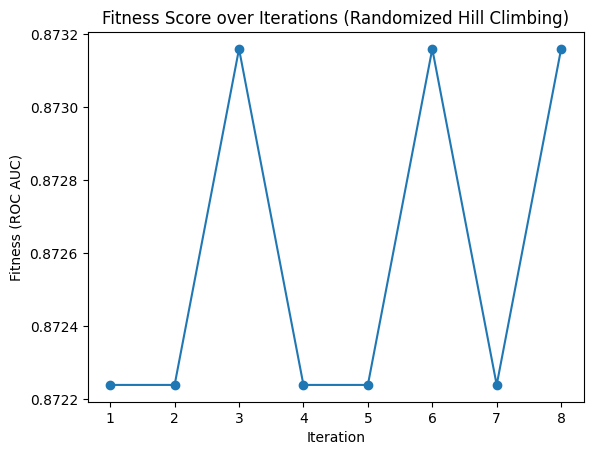

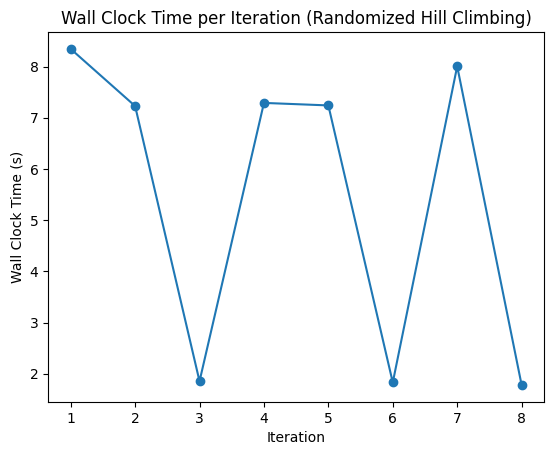

Best Combination for Randomized Hill Climbing: average, ROC AUC: 0.8732


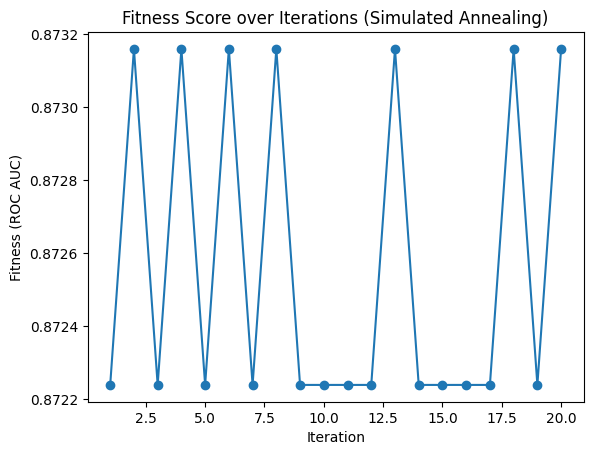

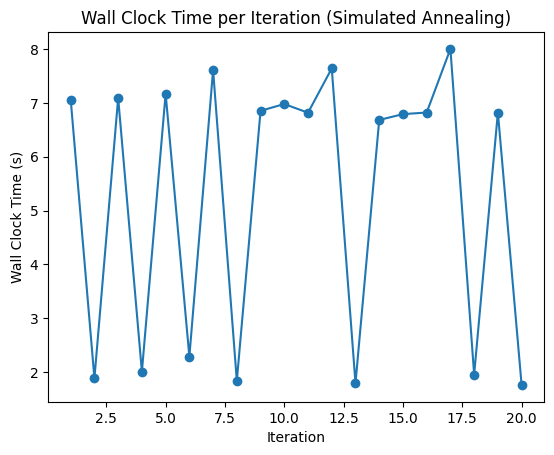

Best Combination for Simulated Annealing: concatenate, ROC AUC: 0.8732


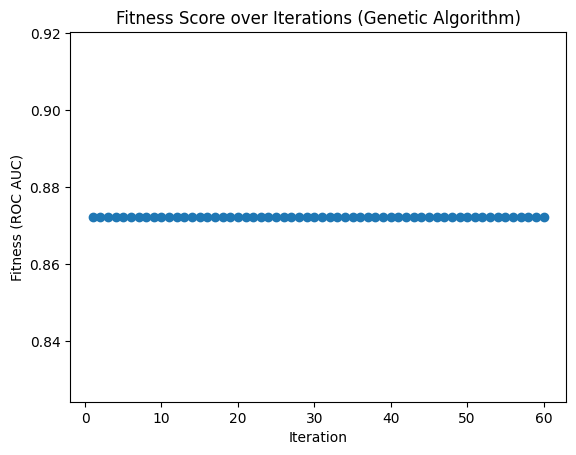

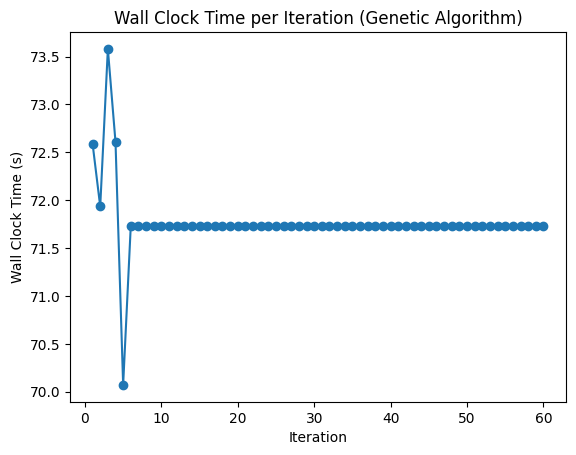

Best Combination for Genetic Algorithm: concatenate, ROC AUC: 0.8722


In [34]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import time
import random

# Function to generate ECFPs
def generate_ecfp(smiles, radius=2, bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(bits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, int(radius), nBits=int(bits)))

# Combine ECFPs
def combine_ecfps(ecfp1, ecfp2, ecfp3, ecfp_molecule, method='concatenate'):
    if method == 'concatenate':
        return np.concatenate([ecfp1, ecfp2, ecfp3, ecfp_molecule])
    elif method == 'average':
        return np.mean([ecfp1, ecfp2, ecfp3, ecfp_molecule], axis=0)
    else:
        raise ValueError("Unknown combination method")

# Evaluation function for combination method
def evaluate_combination_method(X, y, method):
    combined_ecfp = np.array([combine_ecfps(row['ecfp1'], row['ecfp2'], row['ecfp3'], row['ecfp_molecule'], method) for _, row in df.iterrows()])
    X_combined = np.array([np.concatenate([ecfp, protein]) for ecfp, protein in zip(combined_ecfp, protein_onehot)])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = []

    for train_index, val_index in kf.split(X_combined):
        X_train, X_val = X_combined[train_index], X_combined[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Train a simple logistic regression model
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        roc_aucs.append(roc_auc)
    
    return np.mean(roc_aucs)

# Randomized Hill Climbing for ECFP Combination Optimization
def randomized_hill_climbing_ecfp(X, y, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_method = 'concatenate'
    best_score = 0

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0

    for iteration in range(config.iterations):
        start_time = time.time()
        current_score = evaluate_combination_method(X, y, best_method)
        fitness_scores.append(current_score)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += 1

        if current_score > best_score:
            best_score = current_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        # Randomly choose a new method
        best_method = random.choice(['concatenate', 'average'])

        print(f"Iteration {iteration + 1}/{config.iterations}, Method: {best_method}, ROC AUC: {current_score:.4f}")

    return best_method, best_score, fitness_scores, iteration_times, function_evaluations

# Simulated Annealing for ECFP Combination Optimization
def simulated_annealing_ecfp(X, y, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    best_method = 'concatenate'
    best_score = 0

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0
    T = 1.0
    T_min = 0.0001
    alpha = 0.9

    for iteration in range(config.iterations):
        start_time = time.time()
        current_score = evaluate_combination_method(X, y, best_method)
        fitness_scores.append(current_score)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += 1

        if current_score > best_score:
            best_score = current_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        ap = math.exp((current_score - best_score) / T)
        if current_score > best_score or np.random.uniform(0, 1) < ap:
            best_score = current_score

        T = T * alpha

        # Randomly choose a new method
        best_method = random.choice(['concatenate', 'average'])

        print(f"Iteration {iteration + 1}/{config.iterations}, Method: {best_method}, ROC AUC: {current_score:.4f}")

    return best_method, best_score, fitness_scores, iteration_times, function_evaluations

# Genetic Algorithm for ECFP Combination Optimization
def genetic_algorithm_ecfp(X, y, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    population = ['concatenate' for _ in range(config.pop_size)]
    best_method = 'concatenate'
    best_score = 0

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0

    for generation in range(config.generations):
        start_time = time.time()

        population_fitness = [evaluate_combination_method(X, y, method) for method in population]
        fitness_scores.extend(population_fitness)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += config.pop_size

        best_fitness = max(population_fitness)
        if best_fitness > best_score:
            best_score = best_fitness
            best_method = population[np.argmax(population_fitness)]
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive generations. Stopping early.")
            break

        new_population = []
        for _ in range(config.pop_size):
            parents = random.sample(population, 2)
            child = random.choice(parents)
            new_population.append(child)

        population = new_population

        print(f"Generation {generation + 1}/{config.generations}, Best Method: {best_method}, Best ROC AUC: {best_fitness:.4f}")

    return best_method, best_score, fitness_scores, iteration_times, function_evaluations

# Main execution
results_rhc = []
results_sa = []
results_ga = []

for seed in config.seeds:
    result = randomized_hill_climbing_ecfp(X, y, config, seed)
    results_rhc.append(result)
    result = simulated_annealing_ecfp(X, y, config, seed)
    results_sa.append(result)
    result = genetic_algorithm_ecfp(X, y, config, seed)
    results_ga.append(result)

# Function to aggregate results
def aggregate_results(results):
    max_length = max(len(result[2]) for result in results)
    for result in results:
        while len(result[2]) < max_length:
            result[2].append(result[2][-1])
        while len(result[3]) < max_length:
            result[3].append(result[3][-1])

    avg_fitness_scores = np.mean([result[2] for result in results], axis=0)
    std_fitness_scores = np.std([result[2] for result in results], axis=0)
    avg_iteration_times = np.mean([result[3] for result in results], axis=0)
    std_iteration_times = np.std([result[3] for result in results], axis=0)
    best_combination = max(results, key=lambda x: x[1])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

# Aggregating and plotting for Randomized Hill Climbing
avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, best_combination_rhc = aggregate_results(results_rhc)
plot_aggregated_results(avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, 'Randomized Hill Climbing')
print(f"Best Combination for Randomized Hill Climbing: {best_combination_rhc[0]}, ROC AUC: {best_combination_rhc[1]:.4f}")

# Aggregating and plotting for Simulated Annealing
avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, best_combination_sa = aggregate_results(results_sa)
plot_aggregated_results(avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, 'Simulated Annealing')
print(f"Best Combination for Simulated Annealing: {best_combination_sa[0]}, ROC AUC: {best_combination_sa[1]:.4f}")

# Aggregating and plotting for Genetic Algorithm
avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, best_combination_ga = aggregate_results(results_ga)
plot_aggregated_results(avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, 'Genetic Algorithm')
print(f"Best Combination for Genetic Algorithm: {best_combination_ga[0]}, ROC AUC: {best_combination_ga[1]:.4f}")


### Neural Network Optimization

To implement this task, we need to follow these steps:

1. Freeze the weights of the neural network from the first assignment.
2. Use the three random optimization algorithms (Randomized Hill Climbing, Simulated Annealing, Genetic Algorithm) to replace backpropagation for weight updates.
3. Compare the performance of the neural network with frozen weights and the networks trained with the random optimization techniques.

### Freeze the Weights of the NN

In [26]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import duckdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# Load and preprocess data
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()
query = f"""
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 0 ORDER BY random() LIMIT 1500)
    UNION ALL
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 ORDER BY random() LIMIT 1500)
"""
df = con.query(query).df()
con.close()

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)]
y = df['binds'].values

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:45] DEPRECATION WARNING: please use MorganGenerator
[00:59:46] DEPRECATION WARNING: please use MorganGenerator
[00:59:46] DEPRECATION WARNING: please use MorganGenerator
[00:59:46] DEPRECATION WARNING: please use MorganGenerator
[00:59:46] DEPRECATION WARNING: please use MorganGenerator
[00:59:46] DEPRECATION WARNING: please use MorganGenerat

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}
Best cross-validation score for MLP: 0.8099999999999999

Evaluation for MLP:
Accuracy: 0.8583333333333333
ROC AUC Score: 0.924703053511594
F1 Score: 0.8516579406631762
Average Precision Score: 0.9205544200170849


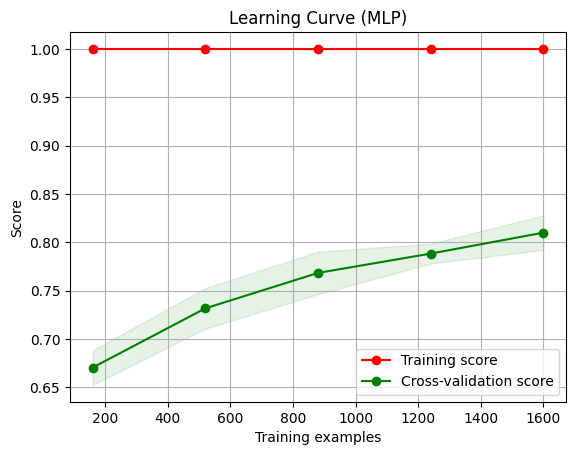

In [27]:
# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Train the neural network using backpropagation
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

mlp_grid_search = GridSearchCV(mlp_pipeline, param_grid=mlp_param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train, y_train)

print("Best parameters for MLP:", mlp_grid_search.best_params_)
print("Best cross-validation score for MLP:", mlp_grid_search.best_score_)
mlp_best = mlp_grid_search.best_estimator_

# Plot learning curve for the best MLP model
plot_learning_curve(mlp_best, "Learning Curve (MLP)", X_train, y_train, cv=3, n_jobs=-1)

# Evaluation Metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))

print("\nEvaluation for MLP:")
evaluate_model(mlp_best, X_test, y_test)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerator
[01:37:15] DEPRECATION WARNING: please use MorganGenerat

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.05, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}
Best cross-validation score for MLP: 0.7883333333333334

Evaluation for MLP:
Accuracy: 0.83
ROC AUC Score: 0.9106989791942648
F1 Score: 0.8222996515679443
Average Precision Score: 0.9069732865312228
Iteration 1/20, ROC AUC: 0.8954
Iteration 2/20, ROC AUC: 0.9321
Iteration 3/20, ROC AUC: 0.9798
Iteration 4/20, ROC AUC: 0.9969
Iteration 5/20, ROC AUC: 0.9998
Iteration 6/20, ROC AUC: 1.0000
Iteration 7/20, ROC AUC: 1.0000
Iteration 8/20, ROC AUC: 1.0000
Iteration 9/20, ROC AUC: 1.0000
Iteration 10/20, ROC AUC: 1.0000
Iteration 11/20, ROC AUC: 1.0000
No improvement for 5 consecutive iterations. Stopping early.
Iteration 1/20, ROC AUC: 0.8954
Iteration 2/20, ROC AUC: 0.9319
Iteration 3/20, ROC AUC: 0.9794
Iteration 4/20, ROC AUC: 0.9947
Iteration 5/20, ROC AUC: 0.9999

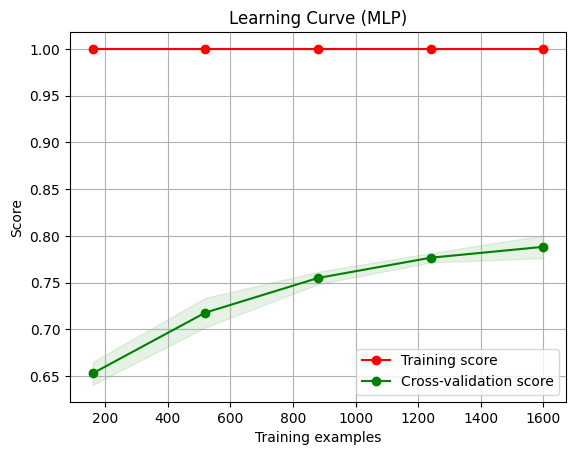

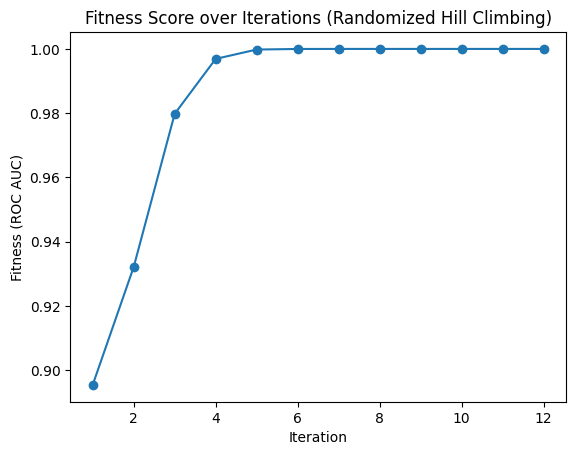

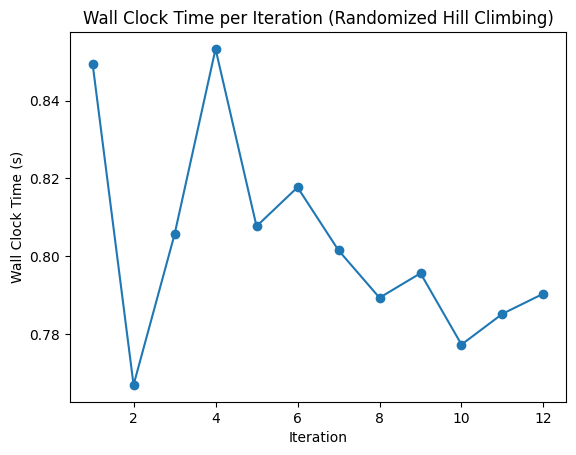

Best Combination for Randomized Hill Climbing: ROC AUC: 1.0000


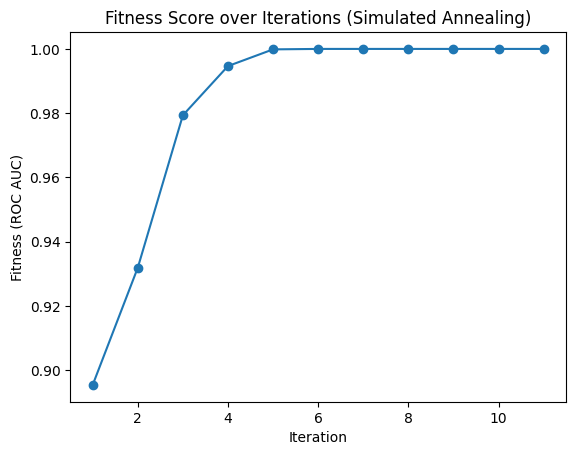

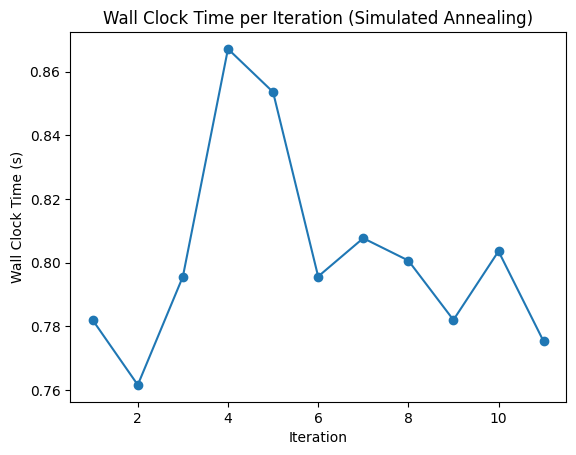

Best Combination for Simulated Annealing: ROC AUC: 1.0000


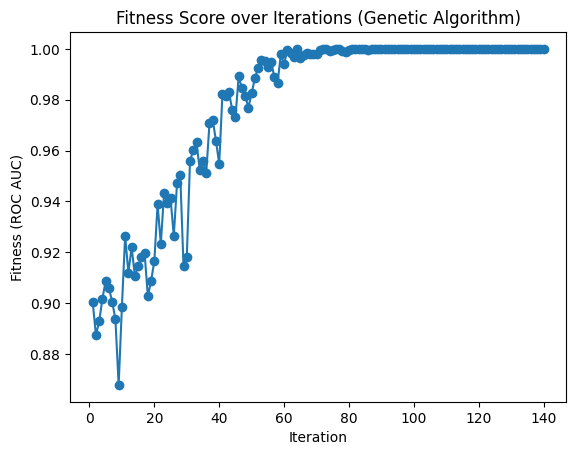

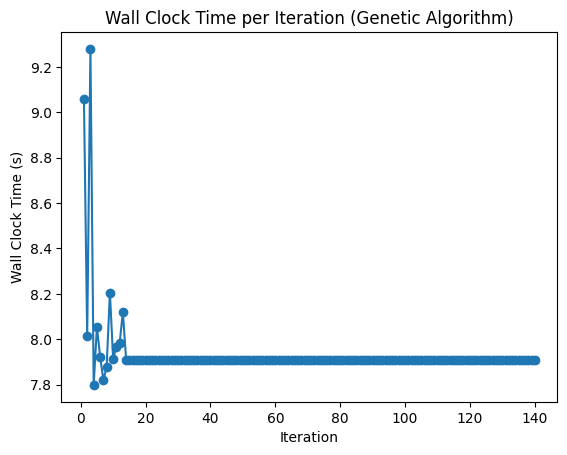

Best Combination for Genetic Algorithm: ROC AUC: 1.0000


In [31]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import duckdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import math

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

class MoleculeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

def generate_ecfp(molecule, radius=2, bits=1024):
    if molecule is None:
        return [0] * bits
    return list(AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=bits))

# Load and preprocess data
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.parquet'

con = duckdb.connect()
query = f"""
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 0 ORDER BY random() LIMIT 1500)
    UNION ALL
    (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 ORDER BY random() LIMIT 1500)
"""
df = con.query(query).df()
con.close()

# Convert SMILES to RDKit molecules
df['molecule'] = df['molecule_smiles'].apply(Chem.MolFromSmiles)
df['ecfp'] = df['molecule'].apply(generate_ecfp)

# One-hot encode the protein_name
onehot_encoder = OneHotEncoder(sparse_output=False)
protein_onehot = onehot_encoder.fit_transform(df['protein_name'].values.reshape(-1, 1))

# Combine ECFPs and one-hot encoded protein_name
X = [ecfp + list(protein) for ecfp, protein in zip(df['ecfp'], protein_onehot)]
y = df['binds'].values

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets with a fixed random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Train the neural network using backpropagation
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000))
])

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.0001, 0.05],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

mlp_grid_search = GridSearchCV(mlp_pipeline, param_grid=mlp_param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train, y_train)

print("Best parameters for MLP:", mlp_grid_search.best_params_)
print("Best cross-validation score for MLP:", mlp_grid_search.best_score_)
mlp_best = mlp_grid_search.best_estimator_

# Plot learning curve for the best MLP model
plot_learning_curve(mlp_best, "Learning Curve (MLP)", X_train, y_train, cv=3, n_jobs=-1)

# Evaluation Metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))

print("\nEvaluation for MLP:")
evaluate_model(mlp_best, X_test, y_test)

class ExperimentConfig:
    def __init__(self, iterations, patience, seeds, pop_size, generations):
        self.iterations = iterations
        self.patience = patience
        self.seeds = seeds
        self.pop_size = pop_size
        self.generations = generations

# Example configuration
config = ExperimentConfig(
    iterations=20,
    patience=5,
    seeds=[42],
    pop_size=10,
    generations=20
)

def train_nn_with_data(X_train, y_train, X_val, y_val, model, optimizer, criterion, epochs=5):
    train_dataset = MoleculeDataset(X_train, y_train)
    val_dataset = MoleculeDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            targets.extend(labels.tolist())

    roc_auc = roc_auc_score(targets, predictions)
    return roc_auc

# Randomized Hill Climbing for Neural Network Optimization
def randomized_hill_climbing_nn(X_train, y_train, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    input_size = X_train.shape[1]
    model = SimpleNN(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0
    best_score = 0
    best_model_state = None

    for iteration in range(config.iterations):
        start_time = time.time()

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        split = int(0.8 * len(indices))
        train_idx, val_idx = indices[:split], indices[split:]
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        roc_auc = train_nn_with_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, model, optimizer, criterion)
        fitness_scores.append(roc_auc)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += 1

        if roc_auc > best_score:
            best_score = roc_auc
            best_model_state = model.state_dict()
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        print(f"Iteration {iteration + 1}/{config.iterations}, ROC AUC: {roc_auc:.4f}")

    best_model = SimpleNN(input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_score, fitness_scores, iteration_times, function_evaluations

# Simulated Annealing for Neural Network Optimization
def simulated_annealing_nn(X_train, y_train, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    input_size = X_train.shape[1]
    model = SimpleNN(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0
    best_score = 0
    best_model_state = None
    T = 1.0
    T_min = 0.0001
    alpha = 0.9

    for iteration in range(config.iterations):
        start_time = time.time()

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        split = int(0.8 * len(indices))
        train_idx, val_idx = indices[:split], indices[split:]
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        roc_auc = train_nn_with_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, model, optimizer, criterion)
        fitness_scores.append(roc_auc)
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += 1

        if roc_auc > best_score:
            best_score = roc_auc
            best_model_state = model.state_dict()
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive iterations. Stopping early.")
            break

        ap = math.exp((roc_auc - best_score) / T)
        if roc_auc > best_score or np.random.uniform(0, 1) < ap:
            best_score = roc_auc
            best_model_state = model.state_dict()

        T = T * alpha

        print(f"Iteration {iteration + 1}/{config.iterations}, ROC AUC: {roc_auc:.4f}")

    best_model = SimpleNN(input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_score, fitness_scores, iteration_times, function_evaluations

# Genetic Algorithm for Neural Network Optimization
def genetic_algorithm_nn(X_train, y_train, config, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    input_size = X_train.shape[1]
    population = [SimpleNN(input_size) for _ in range(config.pop_size)]

    def evaluate_individual(model):
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        split = int(0.8 * len(indices))
        train_idx, val_idx = indices[:split], indices[split:]
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        roc_auc = train_nn_with_data(X_train_fold, y_train_fold, X_val_fold, y_val_fold, model, optimizer, criterion)
        return roc_auc, model.state_dict()

    fitness_scores = []
    iteration_times = []
    function_evaluations = 0
    no_improvement_counter = 0
    best_score = 0
    best_model_state = None

    for generation in range(config.generations):
        start_time = time.time()

        population_fitness = [evaluate_individual(model) for model in population]
        fitness_scores.extend([fitness for fitness, _ in population_fitness])
        iteration_time = time.time() - start_time
        iteration_times.append(iteration_time)
        function_evaluations += config.pop_size

        best_fitness, best_state = max(population_fitness, key=lambda x: x[0])
        if best_fitness > best_score:
            best_score = best_fitness
            best_model_state = best_state
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= config.patience:
            print(f"No improvement for {config.patience} consecutive generations. Stopping early.")
            break

        new_population = []
        for _ in range(config.pop_size):
            parents = random.sample(population, 2)
            child = SimpleNN(input_size)
            with torch.no_grad():
                for param, p1, p2 in zip(child.parameters(), parents[0].parameters(), parents[1].parameters()):
                    param.copy_(0.5 * (p1 + p2))
            new_population.append(child)

        population = new_population

        print(f"Generation {generation + 1}/{config.generations}, Best ROC AUC: {best_fitness:.4f}")

    best_model = SimpleNN(input_size)
    best_model.load_state_dict(best_model_state)

    return best_model, best_score, fitness_scores, iteration_times, function_evaluations

results_rhc_nn = []
results_sa_nn = []
results_ga_nn = []

for seed in config.seeds:
    result = randomized_hill_climbing_nn(X_train, y_train, config, seed)
    results_rhc_nn.append(result)
    result = simulated_annealing_nn(X_train, y_train, config, seed)
    results_sa_nn.append(result)
    result = genetic_algorithm_nn(X_train, y_train, config, seed)
    results_ga_nn.append(result)

# Function to aggregate results
def aggregate_nn_results(results):
    max_length = max(len(result[2]) for result in results)
    for result in results:
        while len(result[2]) < max_length:
            result[2].append(result[2][-1])
        while len(result[3]) < max_length:
            result[3].append(result[3][-1])

    avg_fitness_scores = np.mean([result[2] for result in results], axis=0)
    std_fitness_scores = np.std([result[2] for result in results], axis=0)
    avg_iteration_times = np.mean([result[3] for result in results], axis=0)
    std_iteration_times = np.std([result[3] for result in results], axis=0)
    best_combination = max(results, key=lambda x: x[1])
    return avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, best_combination

# Function to plot aggregated results
def plot_nn_aggregated_results(avg_fitness_scores, std_fitness_scores, avg_iteration_times, std_iteration_times, algorithm_name):
    plt.figure()
    plt.errorbar(range(1, len(avg_fitness_scores) + 1), avg_fitness_scores, yerr=std_fitness_scores, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness (ROC AUC)')
    plt.title(f'Fitness Score over Iterations ({algorithm_name})')
    plt.show()

    plt.figure()
    plt.errorbar(range(1, len(avg_iteration_times) + 1), avg_iteration_times, yerr=std_iteration_times, fmt='-o')
    plt.xlabel('Iteration')
    plt.ylabel('Wall Clock Time (s)')
    plt.title(f'Wall Clock Time per Iteration ({algorithm_name})')
    plt.show()

# Aggregating and plotting for Randomized Hill Climbing
avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, best_combination_rhc = aggregate_nn_results(results_rhc_nn)
plot_nn_aggregated_results(avg_fitness_scores_rhc, std_fitness_scores_rhc, avg_iteration_times_rhc, std_iteration_times_rhc, 'Randomized Hill Climbing')
print(f"Best Combination for Randomized Hill Climbing: ROC AUC: {best_combination_rhc[1]:.4f}")

# Aggregating and plotting for Simulated Annealing
avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, best_combination_sa = aggregate_nn_results(results_sa_nn)
plot_nn_aggregated_results(avg_fitness_scores_sa, std_fitness_scores_sa, avg_iteration_times_sa, std_iteration_times_sa, 'Simulated Annealing')
print(f"Best Combination for Simulated Annealing: ROC AUC: {best_combination_sa[1]:.4f}")

# Aggregating and plotting for Genetic Algorithm
avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, best_combination_ga = aggregate_nn_results(results_ga_nn)
plot_nn_aggregated_results(avg_fitness_scores_ga, std_fitness_scores_ga, avg_iteration_times_ga, std_iteration_times_ga, 'Genetic Algorithm')
print(f"Best Combination for Genetic Algorithm: ROC AUC: {best_combination_ga[1]:.4f}")
